# Import thư viện

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import cv2
from skimage.feature import hog
import os
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
from keras.models import Model
from keras.layers import SimpleRNN, Dense, Dropout, Input, BatchNormalization, GlobalAveragePooling1D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
# Đọc model tốt nhất
from keras.models import load_model
import matplotlib.pyplot as plt

# Trích xuất đặc trưng từ ảnh

In [4]:
def extract_hog_from_image(img_path, target_size=(320, 320)):
    # Đọc ảnh dưới dạng grayscale
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Không thể đọc ảnh từ đường dẫn: {img_path}")

    # Thay đổi kích thước ảnh
    img = cv2.resize(img, target_size)

    # Tạo mask nhị phân từ ảnh (giá trị ngưỡng 127)
    _, mask = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)

    # Trích xuất đặc trưng HOG
    features, _ = hog(mask, orientations=9, pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2), visualize=True)
    return features

In [5]:
def process_image_folder(folder_path, target_size=(320, 320)):
    features_list = []

    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(folder_path, filename)
            hog_features = extract_hog_from_image(img_path, target_size)
            features_list.append(hog_features)

    return features_list

In [6]:
# Đưa vector đặc trưng về giá trị
def reduce_features_to_scalar(features_list):
    features_array = np.array(features_list)

    # Tính L2 norm (độ dài vector)
    f_t = np.linalg.norm(features_array, axis=1)

    return f_t

In [7]:
def create_feature_dataframe(image_folder, features, col_time='filename', col_feature='f_t'):
    file_names = sorted(os.listdir(image_folder))

    # Chuyển features thành danh sách hai chiều nếu cần
    if isinstance(features, np.ndarray):
        if features.ndim == 1:
            features = features.reshape(-1, 1)  # Chuyển thành mảng 2D nếu là 1D
        features = features.tolist()
    elif isinstance(features, list):
        if all(isinstance(row, (int, float, np.float64, np.int64)) for row in features):
            features = [[row] for row in features]  # Chuyển thành danh sách 2D nếu là danh sách 1D
    else:
        raise TypeError("features phải là list hoặc numpy.ndarray")

    assert len(file_names) == len(features), "Số file ảnh không khớp với số dòng trong features"

    # Tạo DataFrame
    df = pd.DataFrame(features, columns=[col_feature])
    df.insert(0, col_time, file_names)

    return df

# Đọc và xử lý dữ liệu số

In [8]:
def read_data_number(data_path, time_col="thoi_gian"):
    # Đọc dữ liệu từ file CSV
    data = pd.read_csv(data_path)

    # Chuyển đổi cột thời gian sang kiểu datetime và đặt làm index
    data[time_col] = pd.to_datetime(data[time_col])
    data.set_index(time_col, inplace=True)

    # Tái lấy mẫu và tính toán thống kê
    y_t = data[['Mực nước hồ (m)', 'Lưu lượng đến hồ (m³/s)']].resample("D").mean()

    return y_t

In [9]:
def create_dataframe(y_t, time_col="thoi_gian", value_col_1="y_t_1", value_col_2="y_t_2"):
    df = pd.DataFrame({time_col: y_t.index,
                       value_col_1: y_t['Mực nước hồ (m)'].values,
                       value_col_2: y_t['Lưu lượng đến hồ (m³/s)'].values})
    return df

# Kết hợp đặc trưng dữ liệu

### Chuẩn hóa đặc trưng ảnh về khoảng dữ liệu số gốc

In [10]:
def rescale_features(df, col="f_t", new_min=0, new_max=1):
    # Tạo một bản sao của DataFrame để không thay đổi dữ liệu gốc
    df_rescaled = df.copy()

    # Lấy dữ liệu của cột cần chuẩn hóa
    col_data = df[col]
    old_min = col_data.min()
    old_max = col_data.max()

    # Kiểm tra tránh chia cho 0 nếu tất cả giá trị giống nhau
    if old_min == old_max:
        df_rescaled[col] = new_min
    else:
        df_rescaled[col] = new_min + (col_data - old_min) * (new_max - new_min) / (old_max - old_min)

    return df_rescaled

### Xác định điểm bất thường

In [11]:
def adjust_y_t(y_t, f_t, alpha):
    mean_y = y_t.mean()
    std_y = y_t.std()

    # Khoảng tin cậy 99,9% dựa trên trung bình và sai số chuẩn
    a = mean_y - alpha * (std_y / np.sqrt(len(y_t)))
    b = mean_y + alpha * (std_y / np.sqrt(len(y_t)))

    # Áp dụng điều chỉnh dựa trên điều kiện
    adjusted_y = np.where(
        (y_t >= a) & (y_t <= b), mean_y, np.where(y_t > b, ((y_t * f_t + mean_y) / (f_t)), ((y_t * f_t) / (1 + f_t)) )
    )

    return pd.Series(adjusted_y, index=y_t.index)

### Tính biến ngoại sinh X_t

In [12]:
def cal_exogenous_variable(y_t, f_t, alpha, time_col="thoi_gian", y_value_col="y_t_1", filename_col="filename", f_t_col="f_t",
                             year_month_col="year_month", f_t_value_col="f_t_value", X_t_col="X_t"):
    # Kiểm tra các cột cần thiết
    required_y_t_cols = {time_col, y_value_col}
    required_f_t_cols = {filename_col, f_t_col}
    if not required_y_t_cols.issubset(y_t.columns):
        raise ValueError(f"DataFrame y_t cần chứa các cột: {required_y_t_cols}")
    if not required_f_t_cols.issubset(f_t.columns):
        raise ValueError(f"DataFrame f_t cần chứa các cột: {required_f_t_cols}")

    # Đảm bảo không thay đổi dữ liệu gốc
    y_t = y_t.copy()
    f_t = f_t.copy()

    # Chuyển đổi cột thời gian sang kiểu datetime và tạo cột year_month
    y_t[time_col] = pd.to_datetime(y_t[time_col])
    y_t[year_month_col] = y_t[time_col].dt.strftime("%Y-%m")

    # Chuẩn hóa tên file trong f_t và tạo cột year_month
    f_t[year_month_col] = (
        f_t[filename_col]
        .str.replace(".jpg", "", regex=True)
        .str.replace("_", "-", regex=False)
    )

    # Tạo từ điển ánh xạ: year_month -> f_t
    mapping = f_t.set_index(year_month_col)[f_t_col].to_dict()

    # Ánh xạ giá trị f_t tương ứng vào y_t; nếu không có giá trị tương ứng, gán mặc định 1.0
    y_t[f_t_value_col] = y_t[year_month_col].map(mapping).fillna(1.0)

    # Điều chỉnh y_t thành X_t sử dụng hàm adjust_y_t (hàm này cần được định nghĩa)
    y_t[X_t_col] = adjust_y_t(y_t[y_value_col], y_t[f_t_value_col], alpha)
    # y_t[X_t_col] = general_transition(y_t[y_value_col], y_t[f_t_value_col], alpha, delta=0.5)

    return y_t[[time_col, X_t_col]]

In [13]:
def plot_with_confidence_interval(X_t, y_t, time_col="thoi_gian", x_col="X_t", y_col="y_t_1", alpha=3.291):
    # Tính trung bình và độ lệch chuẩn của y_t
    mean_yt = y_t[y_col].mean()
    std_yt = y_t[y_col].std()

    # Tính khoảng tin cậy 99.9%
    ci_lower = mean_yt - alpha * (std_yt / np.sqrt(len(y_t)))
    ci_upper = mean_yt + alpha * (std_yt / np.sqrt(len(y_t)))

    # Tạo figure với kích thước đã cho
    plt.figure(figsize=(10, 6))

    # Vẽ giá trị X_t dưới dạng scatter
    plt.scatter(X_t[time_col], X_t[x_col], color='blue', label=x_col, s=20)

    # Vẽ giá trị y_t dưới dạng đường line
    plt.plot(X_t[time_col], y_t[y_col], color='red', label=y_col, linewidth=2)

    # Vẽ vùng khoảng tin cậy 99.9%
    plt.fill_between(X_t[time_col], ci_lower, ci_upper,
                     color='gray', alpha=0.3, label='99.9% CI')

    # Cấu hình biểu đồ
    plt.title(f"Biểu đồ của {x_col} và {y_col} theo thời gian với khoảng tin cậy 99.9%")
    plt.xlabel("Thời gian")
    plt.ylabel("Giá trị")
    plt.legend(loc='upper left')
    plt.grid(True)

    # Hiển thị biểu đồ
    plt.show()

# Áp dụng LSTM để dự đoán

### Tiền xử lý dữ liệu

In [14]:
def create_dataset(X: pd.DataFrame, y: pd.DataFrame, n_steps: int):
    Xs, ys = [], []
    for i in range(len(X) - n_steps):
        Xs.append(X.iloc[i : i + n_steps].values)        # lấy n_steps dòng liên tiếp
        ys.append(y.iloc[i + n_steps].values)            # lấy giá trị ở dòng i+n_steps
    return np.array(Xs), np.array(ys).reshape(-1, 1)      # reshape cho y thành (samples, 1)

### Chia dữ liệu

In [15]:
# Chuẩn hóa dữ liệu
def split_train_test(X_data, y_data):
    # Chia dữ liệu thành tập huấn luyện, kiểm tra và test
    train_length = int(len(X_data) * 0.85)

    X_train, y_train = X_data[:train_length], y_data[:train_length]
    X_test, y_test = X_data[train_length:], y_data[train_length:]

    print("Kích thước X_train:", X_train.shape)
    print("Kích thước X_test:", X_test.shape)
    print("Kích thước y_train:", y_train.shape)
    print("Kích thước y_test:", y_test.shape)

    return X_train, y_train, X_test, y_test

In [16]:
import numpy as np
from sklearn.model_selection import KFold

def split_data(X_data, y_data, n_splits=5, random_state=42):
    # 1) Large folds trên dữ liệu gốc
    kf_large = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    large_folds = [test_idx for _, test_idx in kf_large.split(X_data)]

    # 2) Với mỗi large fold, chia thành small folds
    small_folds = []  # small_folds[i] = list length n_splits, mỗi phần là chỉ số gốc
    for large_idx in large_folds:
        X_large = X_data[large_idx]
        kf_small = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
        small_idx_list = []
        for _, small_idx in kf_small.split(X_large):
            # small_idx là chỉ số relative trong X_large, chuyển về chỉ số gốc
            small_idx_list.append(large_idx[small_idx])
        small_folds.append(small_idx_list)

    # 3) Tạo các split train/val
    splits = []
    for k in range(n_splits):
        # val: small fold k của mỗi large fold
        val_idx = np.concatenate([small_folds[i][k] for i in range(n_splits)], axis=0)
        # train: tất cả small fold j != k
        train_idx = np.concatenate(
            [small_folds[i][j]
             for i in range(n_splits)
             for j in range(n_splits) if j != k],
            axis=0
        )

        X_train, y_train = X_data[train_idx], y_data[train_idx]
        X_val,   y_val   = X_data[val_idx],   y_data[val_idx]
        splits.append((X_train, y_train, X_val, y_val))

    return splits


### Xây dựng mô hình LSTM

In [17]:
def build_forecast_model(time_steps, features, lstm_units=[64, 32], dropout_rate=0.3):
    inp = Input(shape=(time_steps, features))

    # Bi-directional Encoder
    x = SimpleRNN(lstm_units[0], return_sequences=True, activation='tanh')(inp)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    x = SimpleRNN(lstm_units[1], return_sequences=True, activation='tanh')(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    # Pooling để gom thông tin cả chuỗi
    x = GlobalAveragePooling1D()(x)

    # Dense layers
    x = Dense(32, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    # Output scalar
    out = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inp, outputs=out)
    return model

In [18]:
def train_model(X_train, y_train, X_val, y_val, epochs=100, batch_size=32, save_best_model='best_model.h5', initial_lr=1e-3):
    tf.keras.backend.clear_session()

    time_steps, features = X_train.shape[1], X_train.shape[2]
    model = build_forecast_model(time_steps, features)

    # Compile với optimizer và loss phù hợp cho hồi quy
    optimizer = Adam(learning_rate=initial_lr)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Callbacks: lưu model tốt nhất, dừng sớm, giảm lr khi plateau
    checkpoint = ModelCheckpoint(save_best_model, monitor='val_loss',save_best_only=True, mode='min', verbose=1)

    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=[checkpoint],
                        verbose=2)

    # Nạp lại weights tốt nhất trước khi return
    model.load_weights(save_best_model)
    return model, history

### Đánh giá mô hình

In [19]:
# Xác định điểm bất thường
def evaluate_outside_confidence(y_test, y_true, alpha=3.291):
    # Tính trung bình và độ lệch chuẩn của y_test
    mean_yt = np.mean(y_test)
    std_yt = np.std(y_test, ddof=1)  # ddof=1 để tính std của mẫu

    # Tính khoảng tin cậy 99.9%
    ci_lower = mean_yt - alpha * (std_yt / np.sqrt(len(y_test)))
    ci_upper = mean_yt + alpha * (std_yt / np.sqrt(len(y_test)))

    # Xác định các index mà y_test nằm ngoài khoảng tin cậy
    outside_ci_indices = np.where((y_test < ci_lower) | (y_test > ci_upper))[0]

    # Truy xuất dữ liệu đúng cách
    y_t_outside = y_test[outside_ci_indices]
    y_true_outside = y_true[outside_ci_indices]

    return y_t_outside, y_true_outside

In [20]:
def evaluate_metrics(y_true, y_pred):
    # Chuyển về numpy array 1D để mọi phép tính sum đều cho ra scalar
    y_true_arr = np.ravel(y_true)
    y_pred_arr = np.ravel(y_pred)

    mae = round(mean_absolute_error(y_true_arr, y_pred_arr), 6)
    mse = round(mean_squared_error(y_true_arr, y_pred_arr), 6)
    rmse = round(np.sqrt(mse), 6)

    # Tính sai số dự báo
    errors = y_true_arr - y_pred_arr

    # Tracking Signal: TS = Tổng sai số dự báo tích lũy / Tổng độ lệch tuyệt đối của sai số
    tracking_signal = np.sum(errors) / np.sum(np.abs(errors))
    tracking_signal = round(tracking_signal, 6)

    # NSE (Nash–Sutcliffe Efficiency):
    # NSE = 1 - [ sum((y_true - y_pred)^2) / sum((y_true - mean(y_true))^2 ) ]
    numerator   = np.sum((y_true_arr - y_pred_arr) ** 2)
    denominator = np.sum((y_true_arr - np.mean(y_true_arr)) ** 2)

    # Sau khi ravel, denominator là float; chỉ cần so sánh bình thường
    if denominator == 0:
        nse = np.nan
    else:
        nse = 1 - numerator / denominator
        nse = round(nse, 6)

    return {
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "Tracking Signal": tracking_signal,
        "NSE": nse
    }

### Dự báo và trực quan

In [21]:
# Trực quan hóa dữ liệu dự báo không dùng index
def plot_forecast(y_true, y_pred, title="Lake level forecast", alpha=3.291):
    # Tính trung bình và độ lệch chuẩn của y_true
    mean_yt = np.mean(y_true)
    std_yt = np.std(y_true, ddof=1)

    # Tính khoảng tin cậy 99.9%
    ci_lower = mean_yt - alpha * (std_yt / np.sqrt(len(y_true)))
    ci_upper = mean_yt + alpha * (std_yt / np.sqrt(len(y_true)))

    # Tạo trục x là các chỉ mục tuần tự
    x = np.arange(len(y_true))

    # Vẽ biểu đồ
    plt.figure(figsize=(10, 5))

    # Vẽ dữ liệu thực tế
    plt.plot(x, y_true, label="Actual value", color="blue", linestyle='-', alpha=0.7)

    # Vẽ dự báo
    plt.plot(x, y_pred, label="Predicted value", color="red", linestyle='--', alpha=0.7)

    # Vẽ vùng khoảng tin cậy 99.9%
    plt.fill_between(x, ci_lower, ci_upper, color='gray', alpha=0.3, label='99.9% CI')

    # Thiết lập tiêu đề và nhãn
    plt.title(title)
    plt.xlabel("Time Steps")
    plt.ylabel("Water Level (m)")
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True, linestyle="--", alpha=0.5)

    # Hiển thị biểu đồ
    plt.show()

# Thực hiện từng phần

### Tiền xử lý dữ liệu ảnh

In [22]:
# Đọc dữ liệu ảnh và trích xuất HOG
folder_img = r"/content/drive/MyDrive/CoChau/EAI-2024/DataSetAnKhe/images_AnKhe"
features = process_image_folder(folder_img)

# Đưa vector đặc trưng về giá trị
f_t_features = reduce_features_to_scalar(features)
f_t = create_feature_dataframe(folder_img, f_t_features, col_time='filename', col_feature='f_t')

### Tiền xử lý dữ liệu số

In [23]:
# Đọc dữ liệu đầu vào
path_data = r"/content/drive/MyDrive/CoChau/EAI-2024/DataSetAnKhe/data_so_AnKhe/AnKhe.csv"
data = read_data_number(path_data, time_col="thoi_gian")

# Tạo DataFrame chứa thời gian và mực nước
y_t = create_dataframe(data, time_col="thoi_gian", value_col_1="y_t_1", value_col_2="y_t_2")
y_t.head()

,thoi_gian,y_t_1,y_t_2
0,2019-01-01,428.010417,7.393333
1,2019-01-02,427.963333,4.666667
2,2019-01-03,427.939167,4.500000
3,2019-01-04,427.883333,3.953750
4,2019-01-05,427.837917,4.902500


### Chuẩn hóa khoảng và kết hợp đặc trưng

In [24]:
# Chuẩn hóa đặc trưng ảnh về khoảng dữ liệu mực nước gốc
f_t = rescale_features(f_t, col="f_t", new_min=y_t['y_t_1'].min(), new_max=y_t['y_t_1'].max())

In [25]:
# Tính X_t
alpha = 3.291 # 99.9%
X_t = cal_exogenous_variable(y_t, f_t, alpha)

# Trực quan X_t
# plot_with_confidence_interval(X_t, y_t, time_col="thoi_gian", x_col="X_t", y_col="y_t_1", alpha=alpha)

### Chia dữ liệu

In [26]:
# Chuyển 'thoi_gian' về datetime để đảm bảo kiểu dữ liệu đúng
X_t["thoi_gian"] = pd.to_datetime(X_t["thoi_gian"])
y_t["thoi_gian"] = pd.to_datetime(y_t["thoi_gian"])

# Gộp hai DataFrame theo 'thoi_gian'
df_ts = pd.merge(y_t[["thoi_gian", "y_t_1", "y_t_2"]], X_t[["thoi_gian", "X_t"]], on="thoi_gian", how="inner")
df_ts.set_index("thoi_gian", inplace=True)

In [27]:
# Chuẩn hóa dữ liệu
def scaler_data(X, y):
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    X = scaler_X.fit_transform(X)
    y = scaler_y.fit_transform(y)

    return scaler_X, scaler_y, X, y

In [28]:
time_steps = 7

# Tạo chuỗi dữ liệu
X_data, y_data = create_dataset(df_ts[['X_t', 'y_t_1', 'y_t_2']], df_ts[['y_t_1']], time_steps)

# Chia dữ liệu
X_train_val, y_train_val, X_test, y_test = split_train_test(X_data, y_data)

Kích thước X_train: (1546, 7, 3)
Kích thước X_test: (273, 7, 3)
Kích thước y_train: (1546, 1)
Kích thước y_test: (273, 1)


In [29]:
# Chia K-Fold
splits = split_data(X_train_val, y_train_val)

### Huấn luyện ARIMA

—— Fold 1 ——
Epoch 1/100

Epoch 1: val_loss improved from inf to 0.03120, saving model to /content/drive/MyDrive/CoChau/EAI-2024/Results/KFold_HOG_RNN_Fusion_1.keras
78/78 - 7s - 87ms/step - loss: 0.0906 - val_loss: 0.0312
Epoch 2/100

Epoch 2: val_loss improved from 0.03120 to 0.02536, saving model to /content/drive/MyDrive/CoChau/EAI-2024/Results/KFold_HOG_RNN_Fusion_1.keras
78/78 - 1s - 10ms/step - loss: 0.0546 - val_loss: 0.0254
Epoch 3/100

Epoch 3: val_loss did not improve from 0.02536
78/78 - 1s - 8ms/step - loss: 0.0396 - val_loss: 0.0396
Epoch 4/100

Epoch 4: val_loss improved from 0.02536 to 0.01530, saving model to /content/drive/MyDrive/CoChau/EAI-2024/Results/KFold_HOG_RNN_Fusion_1.keras
78/78 - 1s - 9ms/step - loss: 0.0314 - val_loss: 0.0153
Epoch 5/100

Epoch 5: val_loss improved from 0.01530 to 0.00778, saving model to /content/drive/MyDrive/CoChau/EAI-2024/Results/KFold_HOG_RNN_Fusion_1.keras
78/78 - 1s - 9ms/step - loss: 0.0282 - val_loss: 0.0078
Epoch 6/100

Epoch 6:

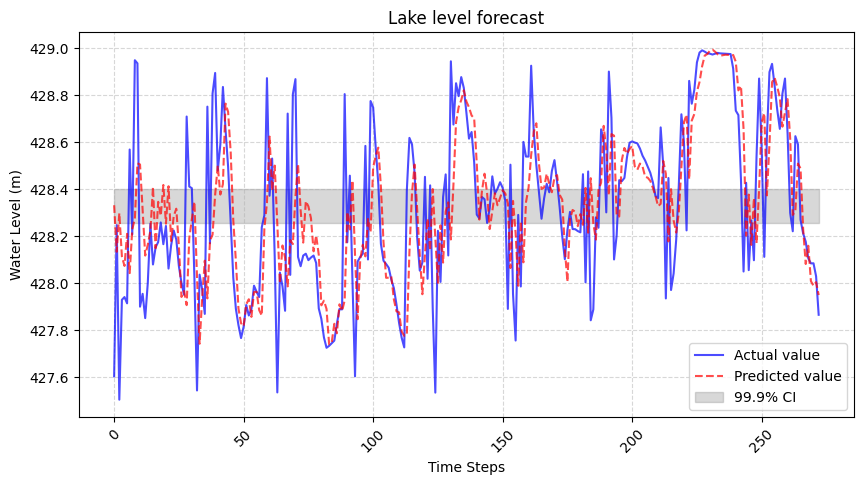

Kết thúc Fold 1. Nghỉ 30s...

—— Fold 2 ——
Epoch 1/100

Epoch 1: val_loss improved from inf to 0.02831, saving model to /content/drive/MyDrive/CoChau/EAI-2024/Results/KFold_HOG_RNN_Fusion_2.keras
78/78 - 7s - 88ms/step - loss: 0.0890 - val_loss: 0.0283
Epoch 2/100

Epoch 2: val_loss improved from 0.02831 to 0.02400, saving model to /content/drive/MyDrive/CoChau/EAI-2024/Results/KFold_HOG_RNN_Fusion_2.keras
78/78 - 1s - 9ms/step - loss: 0.0502 - val_loss: 0.0240
Epoch 3/100

Epoch 3: val_loss improved from 0.02400 to 0.02201, saving model to /content/drive/MyDrive/CoChau/EAI-2024/Results/KFold_HOG_RNN_Fusion_2.keras
78/78 - 1s - 9ms/step - loss: 0.0307 - val_loss: 0.0220
Epoch 4/100

Epoch 4: val_loss improved from 0.02201 to 0.00887, saving model to /content/drive/MyDrive/CoChau/EAI-2024/Results/KFold_HOG_RNN_Fusion_2.keras
78/78 - 1s - 8ms/step - loss: 0.0275 - val_loss: 0.0089
Epoch 5/100

Epoch 5: val_loss improved from 0.00887 to 0.00771, saving model to /content/drive/MyDrive/CoCh

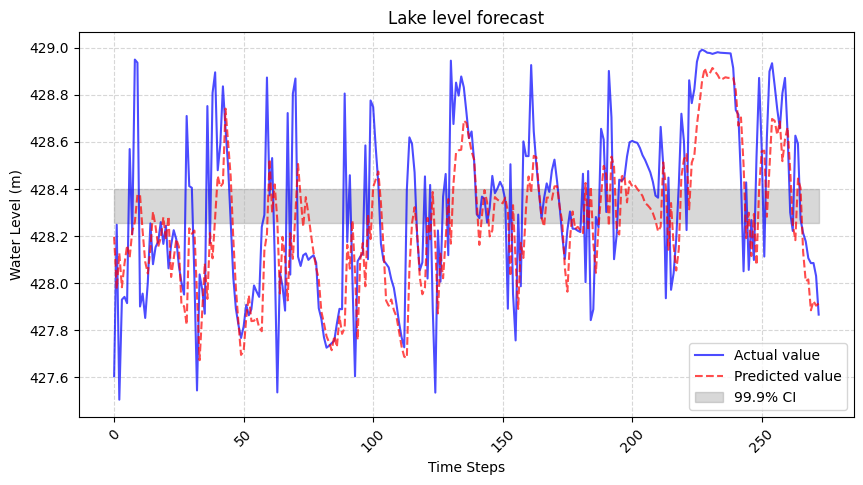

Kết thúc Fold 2. Nghỉ 30s...

—— Fold 3 ——
Epoch 1/100

Epoch 1: val_loss improved from inf to 0.02037, saving model to /content/drive/MyDrive/CoChau/EAI-2024/Results/KFold_HOG_RNN_Fusion_3.keras
78/78 - 7s - 89ms/step - loss: 0.0738 - val_loss: 0.0204
Epoch 2/100

Epoch 2: val_loss improved from 0.02037 to 0.01601, saving model to /content/drive/MyDrive/CoChau/EAI-2024/Results/KFold_HOG_RNN_Fusion_3.keras
78/78 - 1s - 9ms/step - loss: 0.0445 - val_loss: 0.0160
Epoch 3/100

Epoch 3: val_loss improved from 0.01601 to 0.01219, saving model to /content/drive/MyDrive/CoChau/EAI-2024/Results/KFold_HOG_RNN_Fusion_3.keras
78/78 - 1s - 8ms/step - loss: 0.0316 - val_loss: 0.0122
Epoch 4/100

Epoch 4: val_loss did not improve from 0.01219
78/78 - 1s - 16ms/step - loss: 0.0268 - val_loss: 0.0148
Epoch 5/100

Epoch 5: val_loss improved from 0.01219 to 0.00895, saving model to /content/drive/MyDrive/CoChau/EAI-2024/Results/KFold_HOG_RNN_Fusion_3.keras
78/78 - 1s - 9ms/step - loss: 0.0232 - val_loss

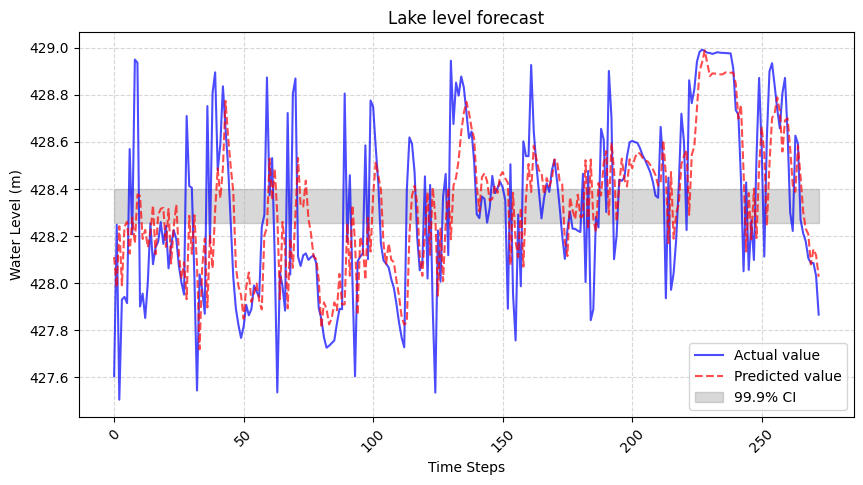

Kết thúc Fold 3. Nghỉ 30s...

—— Fold 4 ——
Epoch 1/100

Epoch 1: val_loss improved from inf to 0.02165, saving model to /content/drive/MyDrive/CoChau/EAI-2024/Results/KFold_HOG_RNN_Fusion_4.keras
78/78 - 6s - 82ms/step - loss: 0.0829 - val_loss: 0.0216
Epoch 2/100

Epoch 2: val_loss improved from 0.02165 to 0.02092, saving model to /content/drive/MyDrive/CoChau/EAI-2024/Results/KFold_HOG_RNN_Fusion_4.keras
78/78 - 1s - 14ms/step - loss: 0.0440 - val_loss: 0.0209
Epoch 3/100

Epoch 3: val_loss improved from 0.02092 to 0.01303, saving model to /content/drive/MyDrive/CoChau/EAI-2024/Results/KFold_HOG_RNN_Fusion_4.keras
78/78 - 1s - 9ms/step - loss: 0.0324 - val_loss: 0.0130
Epoch 4/100

Epoch 4: val_loss improved from 0.01303 to 0.01120, saving model to /content/drive/MyDrive/CoChau/EAI-2024/Results/KFold_HOG_RNN_Fusion_4.keras
78/78 - 1s - 8ms/step - loss: 0.0278 - val_loss: 0.0112
Epoch 5/100

Epoch 5: val_loss improved from 0.01120 to 0.00739, saving model to /content/drive/MyDrive/CoC

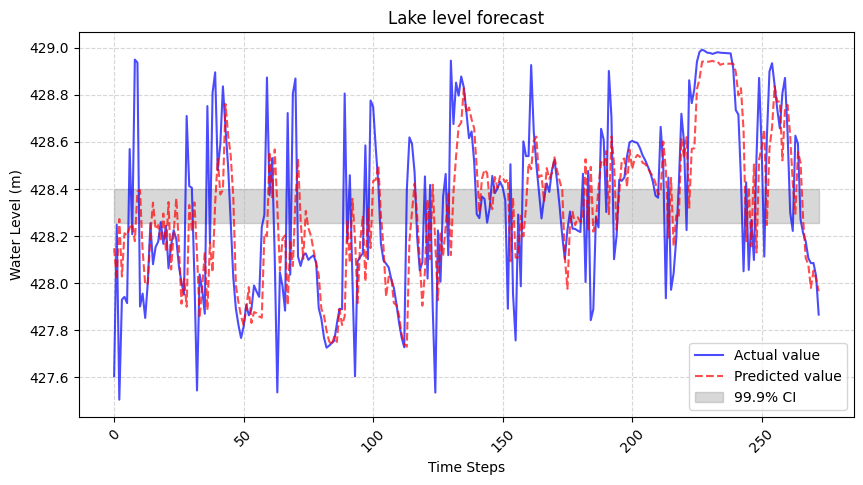

Kết thúc Fold 4. Nghỉ 30s...

—— Fold 5 ——
Epoch 1/100

Epoch 1: val_loss improved from inf to 0.02699, saving model to /content/drive/MyDrive/CoChau/EAI-2024/Results/KFold_HOG_RNN_Fusion_5.keras
78/78 - 7s - 84ms/step - loss: 0.0823 - val_loss: 0.0270
Epoch 2/100

Epoch 2: val_loss did not improve from 0.02699
78/78 - 1s - 7ms/step - loss: 0.0453 - val_loss: 0.0285
Epoch 3/100

Epoch 3: val_loss improved from 0.02699 to 0.02126, saving model to /content/drive/MyDrive/CoChau/EAI-2024/Results/KFold_HOG_RNN_Fusion_5.keras
78/78 - 1s - 9ms/step - loss: 0.0350 - val_loss: 0.0213
Epoch 4/100

Epoch 4: val_loss improved from 0.02126 to 0.02119, saving model to /content/drive/MyDrive/CoChau/EAI-2024/Results/KFold_HOG_RNN_Fusion_5.keras
78/78 - 1s - 9ms/step - loss: 0.0322 - val_loss: 0.0212
Epoch 5/100

Epoch 5: val_loss improved from 0.02119 to 0.01474, saving model to /content/drive/MyDrive/CoChau/EAI-2024/Results/KFold_HOG_RNN_Fusion_5.keras
78/78 - 1s - 9ms/step - loss: 0.0269 - val_loss:

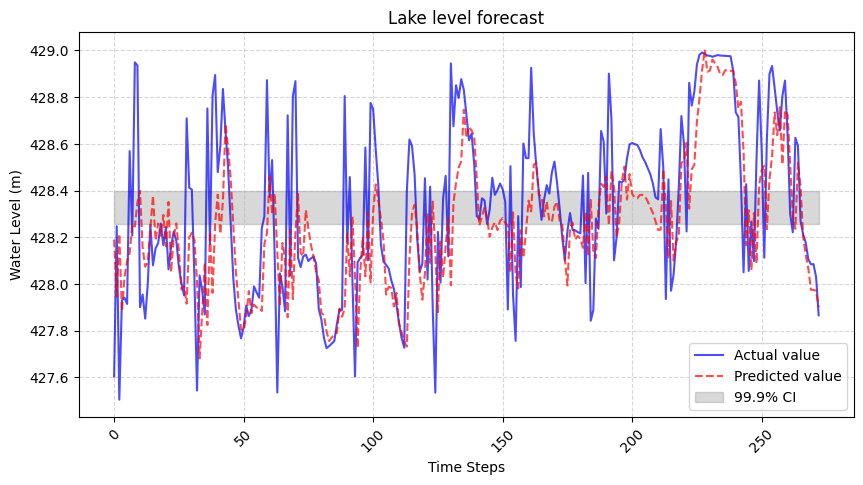

Kết thúc Fold 5. Nghỉ 30s...



In [30]:
rest_time = 30
for i in range(5):
    print(f"—— Fold {i+1} ——")

    # 1) Clear session để release graph cũ
    tf.keras.backend.clear_session()

    # 2) Fit scaler chỉ trên X_train và y_train của fold
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    X_tr = splits[i][0]
    y_tr = splits[i][1]
    X_vl = splits[i][2]
    y_vl = splits[i][3]

    # reshape nếu cần: X có shape (n_samples, time_steps, n_feat) -> flatten để scaler
    n_samples_tr, ts, n_feat = X_tr.shape
    X_tr_flat = X_tr.reshape(-1, n_feat)
    X_vl_flat = X_vl.reshape(-1, n_feat)

    X_tr_s = scaler_X.fit_transform(X_tr_flat).reshape(n_samples_tr, ts, n_feat)
    X_vl_s = scaler_X.transform(X_vl_flat).reshape(X_vl.shape)

    y_tr_s = scaler_y.fit_transform(y_tr.reshape(-1, 1))
    y_vl_s = scaler_y.transform(y_vl.reshape(-1, 1))

    # 3) Train và lưu model tốt nhất của fold
    model, history = train_model(
        X_tr_s, y_tr_s,
        X_vl_s, y_vl_s,
        epochs=100,
        batch_size=16,
        save_best_model=f'/content/drive/MyDrive/CoChau/EAI-2024/Results/KFold_HOG_RNN_Fusion_{i+1}.keras',
        initial_lr=1e-3
    )

    # 4) Tải lại weights tốt nhất
    model = load_model(f'/content/drive/MyDrive/CoChau/EAI-2024/Results/KFold_HOG_RNN_Fusion_{i+1}.keras')

    # 5) Transform X_test (giữ nguyên y_test gốc)
    X_test = X_test  # shape (n_samples_test, ts, n_feat)
    n_samples_test = X_test.shape[0]
    X_test_flat = X_test.reshape(-1, n_feat)
    X_test_s = scaler_X.transform(X_test_flat).reshape(n_samples_test, ts, n_feat)

    # 6) Dự đoán trên tập X_test đã scale
    y_pred_s = model.predict(X_test_s)

    # 7) Inverse scale để về giá trị gốc
    y_pred = scaler_y.inverse_transform(y_pred_s).reshape(-1, 1)

    # 8) Đánh giá metric trên giá trị gốc
    print()
    print(f"Kết quả Fold {i+1}")
    print(evaluate_metrics(y_test, y_pred))

    # 10) Lấy điểm bất thường và đánh giá tiếp
    y_t_out, y_true_out = evaluate_outside_confidence(y_test, y_pred)
    print(evaluate_metrics(y_true_out, y_t_out))

    # 9) Vẽ đồ thị forecast
    plot_forecast(y_test, y_pred)

    print(f"Kết thúc Fold {i+1}. Nghỉ {rest_time}s...\n")

In [31]:
# rest_time = 30
# for i in range(5):
#     print(f"—— Fold {i+1} ——")

#     # 1) Clear session để release graph cũ
#     tf.keras.backend.clear_session()

#     # 2) Chuẩn bị scaler trên X_train, y_train của fold
#     scaler_X = MinMaxScaler()
#     scaler_y = MinMaxScaler()
#     X_tr, y_tr, _, _ = splits[i]

#     # Lấy shape để reshape
#     n_samples_tr, ts, n_feat = X_tr.shape

#     # Fit scaler_X trên X_tr
#     X_tr_flat = X_tr.reshape(-1, n_feat)
#     scaler_X.fit(X_tr_flat)

#     # Fit scaler_y trên y_tr
#     y_tr_flat = y_tr.reshape(-1, 1)
#     scaler_y.fit(y_tr_flat)

#     # 3) Load model đã train sẵn
#     model = load_model(f'./BestModel/KFold_HOG_RNN_Fusion_{i+1}_KN.hdf5')

#     # 4) Chuẩn hoá X_test
#     n_samples_test = X_test.shape[0]
#     X_test_flat    = X_test.reshape(-1, n_feat)
#     X_test_s       = scaler_X.transform(X_test_flat).reshape(n_samples_test, ts, n_feat)

#     # 5) Dự đoán và về giá trị gốc
#     y_pred_s = model.predict(X_test_s)
#     y_pred   = scaler_y.inverse_transform(y_pred_s).reshape(-1, 1)
#     y_true   = y_test.reshape(-1, 1)

#     # 6) Tính statistics cho y_true và y_pred
#     y_true_flat = y_true.flatten()
#     y_pred_flat = y_pred.flatten()

#     mean_true = np.mean(y_true_flat)
#     mean_pred = np.mean(y_pred_flat)
#     std_true  = np.std(y_true_flat)
#     std_pred  = np.std(y_pred_flat)
#     var_true  = np.var(y_true_flat)
#     var_pred  = np.var(y_pred_flat)

#     print("\n— Statistics (y_true vs y_pred) —")
#     print(f"{'':>12} {'y_true':>12} {'y_pred':>12}")
#     print(f"{'mean':>12} {mean_true:12.6f} {mean_pred:12.6f}")
#     print(f"{'std':>12}  {std_true:12.6f}  {std_pred:12.6f}")
#     print(f"{'var':>12}  {var_true:12.6f}  {var_pred:12.6f}\n")